In [1]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
import gc
import sys
from pprint import pprint

#df_13 = pd.read_csv('13_clean.csv')
#df_13.head()

years = ['85', '87', '89', '91', '93', '95', '97', '99', '01', '03', '05', '07', '09', '11', '13']
years_num = [1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013 ]


def combineDataFrame(years, years_num):
    
    df_allYears = pd.DataFrame()
    
    for year, i in zip(years, years_num):
        df = pd.read_csv(year + '_clean.csv')
        df['YEAR'] = i
        df_allYears = df_allYears.append(df)
    
    return df_allYears
    
df_allYears = combineDataFrame(years, years_num)

#Keep only LMED from above set since 'ABL50', 'ABL80', 'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50' are correlated
cols = ['ABL50', 'ABL80', 'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50']
df_allYears.drop(cols, axis=1, inplace=True)


#Keep only 'INCRELAMIPCT' from above set since 'ZINC2', 'TOTSAL' are correlated
cols = ['ZINC2', 'TOTSAL']
df_allYears.drop(cols, axis=1, inplace=True)

#choose columns that are independent, e.g. COSTMED, COSTMEDRELAMITPCT, FMTCOSTMEDRELAMIPCT 
#show the same data in different format; ditto for FMTINCRELAMICAT and INCRELAMIPCT
# drop CONTROL as well
cols = ['CONTROL', 'COSTMED', 'FMTCOSTMEDRELAMICAT', 'FMTINCRELAMICAT']
df_allYears.drop(cols, axis=1, inplace=True)
print(df_allYears.shape)

#removing columns related to cost since these are related to target variable ZSMHC (monthly housing cost)
cols = ['COSTMEDRELAMIPCT', 'BURDEN', 'OTHERCOST', 'UTILITY']
df_allYears.drop(cols, axis=1, inplace=True)
print(df_allYears.shape)

#drop na values
df_allYears = df_allYears.dropna()
print(df_allYears.shape)

#remove values of FMTMETRO set to 9;
df_allYears = df_allYears.loc[~df_allYears['FMTMETRO'].str.contains('9', regex=False)]


#drop FMTSTATUS - earlier generated ill-defined matrix warning for ridge regression;
#values for this column is constanct for several years
df_allYears.drop('FMTSTATUS', axis=1, inplace=True)

#converting REGION from int type to string type
df_allYears['REGION'].apply(str)

#convert categorical variables to indicator variables
df_allYears = pd.get_dummies(df_allYears, drop_first=True)

print(df_allYears.columns)

(771870, 24)
(771870, 20)
(486785, 20)
Index(['AGE', 'BEDRMS', 'FMR', 'INCRELAMIPCT', 'IPOV', 'LMED', 'NUNITS', 'PER',
       'ROOMS', 'VALUE', 'ZSMHC', 'REGION', 'YEAR', 'FMTBUILT_'1960-1979'',
       'FMTBUILT_'1980-1989'', 'FMTBUILT_'1990-1999'', 'FMTBUILT_'2000-2009'',
       'FMTBUILT_'After 2010'', 'FMTBUILT_'not_defined'',
       'FMTASSISTED_'0 Not Assisted'', 'FMTSTRUCTURETYPE_'2 2-4 units'',
       'FMTSTRUCTURETYPE_'3 5-19 units'', 'FMTSTRUCTURETYPE_'4 20-49 units'',
       'FMTSTRUCTURETYPE_'5 50+ units'', 'FMTSTRUCTURETYPE_'6 Mobile Home'',
       'FMTMETRO_'Central City'', 'FMTZADEQ_'2 Moderately Inadequ'',
       'FMTZADEQ_'3 Severely Indadequa''],
      dtype='object')


In [2]:
X = df_allYears.drop(['ZSMHC'], axis=1).values

y = df_allYears['ZSMHC'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

del df_allYears
del X
del y

In [3]:
# Create the parameter grid based on the results of random search
# This parameter grid includes paramaters for best score of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [16, 18, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 500]
}# Create a based model
rf = RandomForestRegressor(random_state=42, n_jobs=1)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose = 2)
grid_search.fit(X_train, y_train)
print('hello world!')

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  51.2s
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   51.2s remaining:    0.0s


[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  50.3s
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  49.3s
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total= 1.6min
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200, total= 1.7min
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_d

[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, total= 4.1min
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=  49.2s
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=  49.0s
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=  49.8s
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200 
[CV]  bootstrap=False, max_

[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500, total= 4.1min
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500, total= 4.0min
[CV] bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, max_depth=16, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500, total= 4.0min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=  57.0s
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total= 2.7min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total= 2.7min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, total= 4.5min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500, total= 4.5min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total= 1.8min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total= 2.7min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total= 2.7min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=300, total= 2.7min
[CV] bootstrap=False, max_depth=18, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=500 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total= 2.0min
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total= 2.0min
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200, total= 2.0min
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300, total= 3.0min
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300 
[CV]  bootstrap=Fals

[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=  57.6s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, total=  57.5s
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total= 1.9min
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200, total= 1.9min
[CV] bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=Fals

[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed: 543.7min finished


hello world!


In [4]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
cv_results = grid_search.cv_results_
best_estimator = grid_search.best_estimator_

In [5]:
pprint(best_params)
pprint(best_score)

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}
0.6194362983053177


In [6]:
index = int(np.argwhere(cv_results['rank_test_score']==1))
pprint(cv_results['mean_fit_time'][index])

276.8467529614766


In [35]:
index = int(np.argwhere(cv_results['rank_test_score']==72))
pprint(cv_results['mean_test_score'][index])

0.6161770887922118


In [8]:
cv_results_df = pd.DataFrame({'n_estimators':cv_results['param_n_estimators'],\
                              'min_samples_split':cv_results['param_min_samples_split'],\
                             'min_samples_leaf':cv_results['param_min_samples_leaf'],\
                             'max_features':cv_results['param_max_features'],\
                              'max_depth':cv_results['param_max_depth'],\
                             'bootstrap':cv_results['param_bootstrap'],\
                             'mean_test_score':cv_results['mean_test_score'],\
                             'mean_fit_time':cv_results['mean_fit_time']})

cv_results_df_subset = cv_results_df.loc[(cv_results_df['mean_fit_time'] < 100)]

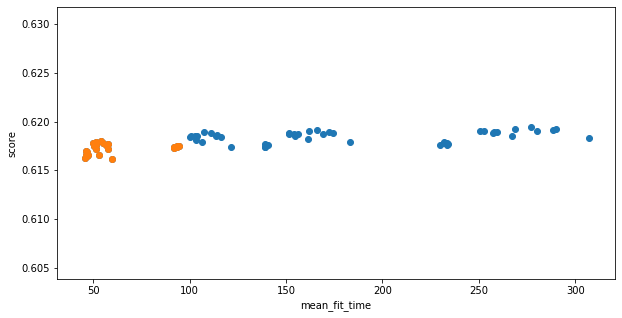

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['mean_fit_time'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['mean_fit_time'],cv_results_df_subset['mean_test_score'])
plt.xlabel('mean_fit_time')
plt.ylabel('score')
plt.show()

In [22]:
max_depth = [16, 18, 20]
min_samples_leaf = [1, 2]
min_samples_split = [2, 5, 10]
n_estimators = [100, 200, 300, 500]

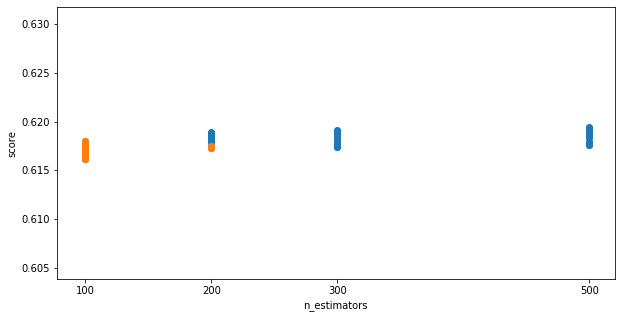

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['n_estimators'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['n_estimators'],cv_results_df_subset['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.xticks(ticks=n_estimators, labels=n_estimators)
plt.show()

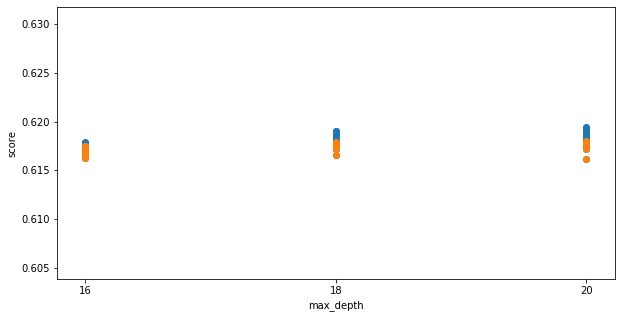

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['max_depth'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['max_depth'],cv_results_df_subset['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('score')
plt.xticks(ticks=max_depth, labels=max_depth)
plt.show()

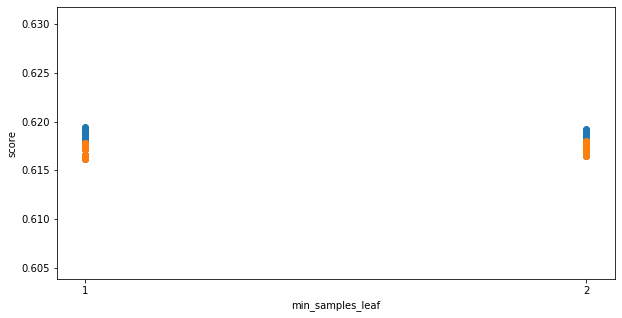

In [23]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['min_samples_leaf'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['min_samples_leaf'],cv_results_df_subset['mean_test_score'])
plt.xlabel('min_samples_leaf')
plt.ylabel('score')
plt.xticks(ticks=min_samples_leaf, labels=min_samples_leaf)
plt.show()

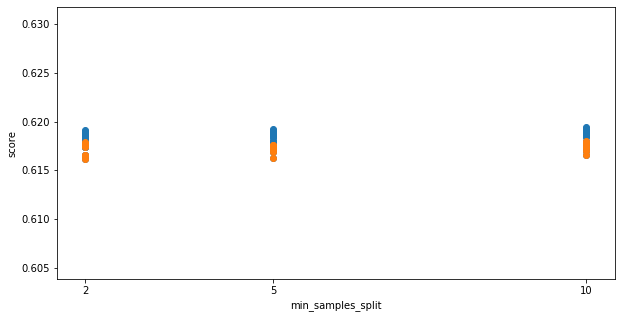

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['min_samples_split'],cv_results_df['mean_test_score'])
plt.scatter(cv_results_df_subset['min_samples_split'],cv_results_df_subset['mean_test_score'])
plt.xlabel('min_samples_split')
plt.ylabel('score')
plt.xticks(ticks=min_samples_split, labels=min_samples_split)
plt.show()

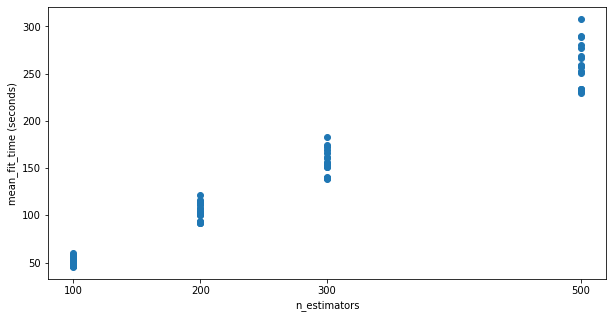

In [37]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['n_estimators'],cv_results_df['mean_fit_time'])
#plt.scatter(cv_results_df_subset['min_samples_split'],cv_results_df_subset['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('mean_fit_time (seconds)')
plt.xticks(ticks=n_estimators, labels=n_estimators)
plt.show()

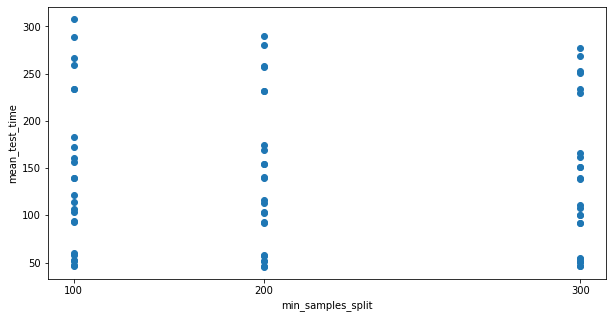

In [29]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['min_samples_split'],cv_results_df['mean_fit_time'])
#plt.scatter(cv_results_df_subset['min_samples_split'],cv_results_df_subset['mean_test_score'])
plt.xlabel('min_samples_split')
plt.ylabel('mean_test_time')
plt.xticks(ticks=min_samples_split, labels=n_estimators)
plt.show()

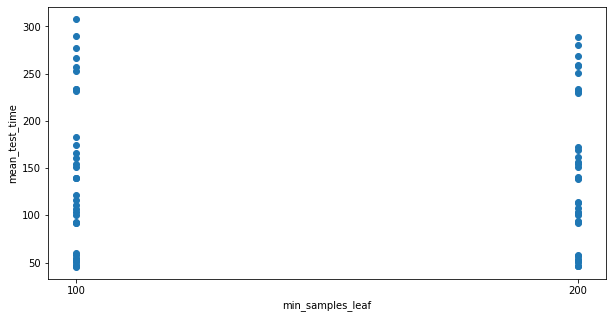

In [30]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['min_samples_leaf'],cv_results_df['mean_fit_time'])
#plt.scatter(cv_results_df_subset['min_samples_split'],cv_results_df_subset['mean_test_score'])
plt.xlabel('min_samples_leaf')
plt.ylabel('mean_test_time')
plt.xticks(ticks=min_samples_leaf, labels=n_estimators)
plt.show()

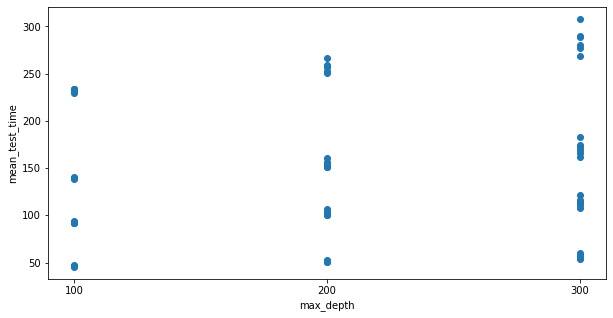

In [31]:
plt.figure(figsize=(10,5))
plt.scatter(cv_results_df['max_depth'],cv_results_df['mean_fit_time'])
#plt.scatter(cv_results_df_subset['min_samples_split'],cv_results_df_subset['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('mean_test_time')
plt.xticks(ticks=max_depth, labels=n_estimators)
plt.show()